In [1]:
%%HTML
<style>
   div#notebook-container    { width: 95%; }
   div#menubar-container     { width: 65%; }
   div#maintoolbar-container { width: 99%; }
</style>

In [2]:
# import sys
# !{sys.executable} -m pip install torchsummary

In [1]:
import sys
sys.path.append("..") # Adds higher directory to python modules path.
from utilities import aggregate_feature_calculators
from utilities import aggregate_feature_calculators_setting as aggcal
from utilities.parallel import Parallel

In [2]:
import pandas as pd
import numpy as np
import os
import os.path as osp
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

from torch_geometric.data import Data, DataLoader
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import QM9
from torch_geometric.datasets import TUDataset
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, ChebConv  # noqa
from torch.nn import Sequential, Linear, ReLU, GRU
import torch_geometric.transforms as T
from torch_geometric.datasets import QM9
from torch_geometric.nn import NNConv, Set2Set
from torch_geometric.data import DataLoader
from torch_geometric.utils import remove_self_loops
from torch_geometric.data import Data

In [3]:
file_folder = 'data/input/champs-scalar-coupling' if 'champs-scalar-coupling' in os.listdir('../data/input/') else '../data/input'
os.listdir(file_folder)

['sample_submission.csv',
 'magnetic_shielding_tensors.csv',
 'potential_energy.csv',
 'scalar_coupling_contributions.csv',
 'dipole_moments.csv',
 'mulliken_charges.csv',
 'train.csv',
 'test.csv',
 'structures.csv',
 'structures']

In [4]:
train = pd.read_csv(f'{file_folder}/train.csv')
test = pd.read_csv(f'{file_folder}/test.csv')
sub = pd.read_csv(f'{file_folder}/sample_submission.csv')

In [5]:
train['type0'] = train['type'].apply(lambda x: int(x[0]))
train['type1'] = train['type'].apply(lambda x: x[1:])

In [6]:
le = LabelEncoder()
le.fit(train.type1.tolist())
int_bond_type = le.transform(train.type1.tolist()) 
train['int_type1']= int_bond_type

In [7]:
test['type0'] = test['type'].apply(lambda x: int(x[0]))
test['type1'] = test['type'].apply(lambda x: x[1:])
int_bond_type = le.transform(test.type1.tolist()) 
test['int_type1']= int_bond_type

In [210]:
train.tail(1)

,id,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,type0,type1,int_type1
4658146,4658146,dsgdb9nsd_133884,17,8,1JHC,117.934,1,JHC,0


In [211]:
test.tail(1)

,id,molecule_name,atom_index_0,atom_index_1,type,type0,type1,int_type1
2505541,7163688,dsgdb9nsd_133885,15,8,1JHC,1,JHC,0


In [213]:
train.molecule_name.unique().shape,test.molecule_name.unique().shape,

((85003,), (45772,))

In [17]:
structures = pd.read_csv(f'{file_folder}/structures.csv')
le = LabelEncoder()
le.fit(structures.atom.tolist())
int_atom = le.transform(structures.atom.tolist()) 
structures['int_atom'] = int_atom

In [215]:
structures.tail(1)

,molecule_name,atom_index,atom,x,y,z,int_atom
2358656,dsgdb9nsd_133885,15,H,1.260745,-1.246754,-1.906767,2


In [232]:
def _worker(item):
    idx = item[0]
    molecule_name = item[1]
    y_group_mean = train[train['molecule_name']==molecule_name]['scalar_coupling_constant'].mean()
    return {'idx':idx, 'y_group_mean':y_group_mean}

def y_mean_std(molecule_names=['dsgdb9nsd_000007', 'dsgdb9nsd_000008']):
    N_ = len(molecule_names)
    segment = N_//100
    df_ = pd.DataFrame()
    for start in tqdm_notebook(range(0, N_, segment)):
        end = start+segment if start+segment < N_ else N_
        res = Parallel(_worker,{}).run(zip(range(start,end,1),molecule_names[start:end]), n_jobs=6)
        df_ = pd.concat([df_, pd.DataFrame(res)], axis=0)
    df_ = df_.sort_values(by=['idx'])
    df_ = df_.reset_index(drop=True)
    return df_

In [233]:
df_ = y_mean_std(train.molecule_name.unique())
y_mean, y_std = df_.y_group_mean.mean(), df_.y_group_mean.std()
y_mean, y_std

(16.84314632949583, 4.054417583301291)

In [3]:
y_mean, y_std = 16.84314632949583, 4.054417583301291

In [13]:
# sns.distplot((df_.y_group_mean-y_mean)/y_std, bins=100)

In [29]:
def _worker(item, df_bonds, df_structures, y_mean=0, y_std=1):
    
    has_y = 'scalar_coupling_constant' in df_bonds.columns
    
    idx = item[0]
    molecule_name = item[1]
    

    
    x = torch.tensor(df_structures[df_structures['molecule_name']==molecule_name].sort_values(by=['atom_index'])[['int_atom']].values, dtype=torch.float)
    pos = torch.tensor(df_structures[df_structures['molecule_name']==molecule_name].sort_values(by=['atom_index'])[['x','y','z']].values, dtype=torch.float)

    edge_index = []
    edge_attr = []

    df_molecule_i = df_bonds[df_bonds['molecule_name']==molecule_name]

    if has_y:
        y_molecule_mean = (df_molecule_i['scalar_coupling_constant'].mean()-y_mean)/y_std
        y = torch.tensor([y_molecule_mean], dtype=torch.float)

    for idx, row in df_molecule_i.iterrows():
        edge_index.append([row['atom_index_0'], row['atom_index_1']])
        edge_index.append([row['atom_index_1'], row['atom_index_0']])
        edge_attr.append([row['type0'], row['int_type1']])
        edge_attr.append([row['type0'], row['int_type1']])

    edge_index = torch.tensor(edge_index, dtype=torch.long)
    edge_attr = torch.tensor(edge_attr, dtype=torch.float)
    if has_y:
        data = Data(x=x, edge_index=edge_index.t().contiguous(), pos=pos, edge_attr=edge_attr, y=y)
    else:
        data = Data(x=x, edge_index=edge_index.t().contiguous(), pos=pos, edge_attr=edge_attr)
    return {'idx':idx, 'molecule_name':molecule_name, 'data':data}

def generate_datalist(df_bonds, df_structures, molecule_names=['dsgdb9nsd_000007', 'dsgdb9nsd_000008'], y_mean=0, y_std=1, path='../data/feats/datalist.pkl'):

    
    N_ = len(molecule_names)
    segment = N_//100
    
    if os.path.exists(path):
        df_ = pd.read_pickle(path)
        data_list = list(df_.T.to_dict().values())
        start_point = df_.shape[0]
    else:
        df_ = pd.DataFrame()
        data_list = []
        start_point = -1
    
    print(start_point)
    for item in tqdm_notebook(enumerate(molecule_names), total=N_):
        if item[0]<=start_point:
            continue
        d_ = _worker(item, **{'df_bonds':df_bonds, 'df_structures':df_structures, 'y_mean':y_mean, 'y_std':y_std})
        data_list.append(d_)
        if item[0]%segment==0:
            pd.DataFrame(data_list).to_pickle(path)
        
    df_ = pd.DataFrame(data_list)
    df_ = df_.sort_values(by=['idx'])
    df_ = df_.reset_index(drop=True)
    df_.to_pickle(path)
    return df_
    

In [31]:
df_data_train = generate_datalist(train, structures, molecule_names=molecule_names, y_mean=y_mean, y_std=y_std)
df_data_train = df_data_train.reset_index(drop=True)
df_data_train = df_data_train.drop(columns=['idx'])

64601


In [45]:
# df_data_train.to_pickle('../data/feats/datalist.pkl')

In [4]:
df_data_train = pd.read_pickle('../data/feats/datalist.pkl')

In [5]:
molecule_names = df_data_train.molecule_name.unique().tolist()

In [117]:
# df_data_train['y'] = df_data_train['data'].apply(lambda x : x.y.item())

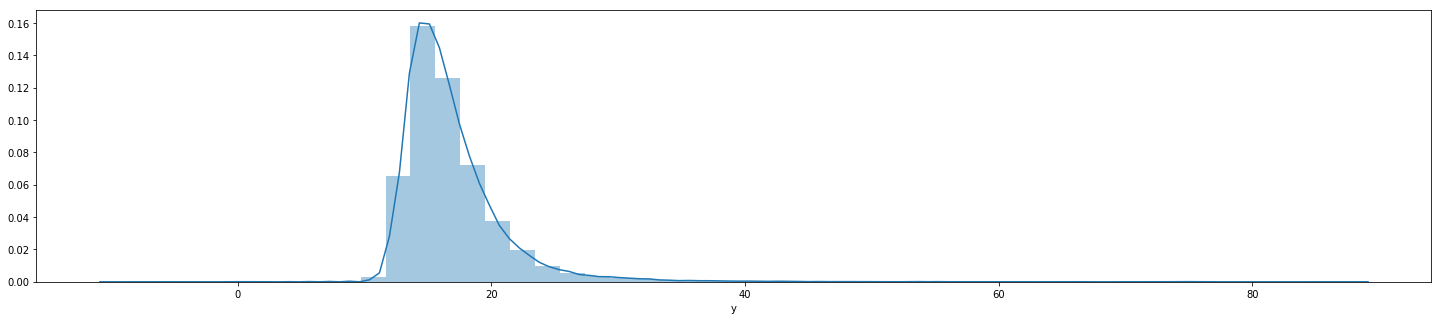

In [141]:
fig = plt.figure(figsize=(25,5))
sns.distplot(df_data_train['y']*y_std+y_mean)

In [6]:
print(len(molecule_names))
test_molecule_names = molecule_names[56668:]
train_molecule_names = molecule_names[:56668]

85003


In [7]:
def generate_dataLoader(df, molecule_names, shuffle=True, batch_size=32, **kwargs):
    data_list = df[df['molecule_name'].isin(molecule_names)]['data'].tolist()
    return DataLoader(data_list, batch_size=batch_size, shuffle=shuffle, **kwargs)

In [8]:
def process(df, param, message, test_loader=None, trial=None):
    
    start_datetime = datetime.datetime.now()
    
    folds = KFold(**param['kfold'])
    splits = list(folds.split(train_molecule_names))
    
    model_cls = eval(param['algorithm']['cls'])
    molecule_names = param['molecule_names']
    his = []

    for fold_n, (train_index, valid_index) in enumerate(splits):

        train_loader = generate_dataLoader(df, molecule_names=[molecule_names[i] for i in train_index], batch_size=32)
        valid_loader = generate_dataLoader(df, molecule_names=[molecule_names[i] for i in valid_index], batch_size=1)

        model = model_cls(**param['algorithm']['init'])
        his = model.fit(train_loader, valid_loader)
        y_pred_valid = model.predict(valid_loader)
        y_pred_test = model.predict(test_loader)
        his.append({'fold_n':fold_n, 'his':his, 'y_pred_valid':y_pred_valid, 'y_pred_test':y_pred_test, 'valid_index':valid_index})
    
    df_his = pd.DataFrame(his)
    trial_i = {'datetime': start_datetime, 'message': message, 'his':df_his, 'param': param.copy()}
    
    return df_his

In [15]:
# torch.cuda.empty_cache()

In [11]:
param = {
    'molecule_names':train_molecule_names,
    'kfold': {
        'n_splits': 5,
        'shuffle': True,
        'random_state': 42,
    },
    'algorithm': {
        'cls': 'QM9Net',
        'init':{
            'num_node_features':1,
            'num_edge_features':2,
            'dim':8,
            'nn_layer1_output_dim':16,
            'y_mean': y_mean,
            'y_std': y_std
        },
        'fit':{
            'epoch':50
        }
    }
}
test_loader = generate_dataLoader(df_data_train, molecule_names=test_molecule_names, batch_size=1)

In [ ]:
trial = []
df_his = process(df_data_train, param, 'no message', test_loader=test_loader, trial=trial)

In [ ]:
pd.DataFrame(trial).to_pickle('../data/trial/QM9Net.pkl')

In [10]:
class QM9Net(object):
    
    def __init__(self, num_node_features, num_edge_features, dim, nn_layer1_output_dim, y_std, y_mean):
        
        self.y_std = y_std
        self.y_mean = y_mean
        self.num_node_features = num_node_features
        self.num_edge_features = num_edge_features
        self.dim = dim
        self.nn_layer1_output_dim = nn_layer1_output_dim
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = Net(num_node_features, num_edge_features, dim, nn_layer1_output_dim).to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.7, patience=5, min_lr=0.00001)
        return


    def fit(self, loader, val_loader, test_loader=None, epoch=100, verbose=1):
        
        best_val_error = None
        his = []
        for epoch in range(1, epoch+1):
            lr = self.scheduler.optimizer.param_groups[0]['lr']
            loss = self._train(loader, self.device, self.model, self.optimizer)
            val_loss = np.mean(self._evaluate(val_loader))
            if type(test_loader) != type(None):
                test_loss = np.mean(self._evaluate(test_loader))
            self.scheduler.step(np.mean(val_loss))
            his.append({'epoch':epoch, 'lr':lr, 'loss':loss, 'val_loss':val_loss})
            if verbose>0:
                print('Epoch: {:03d}, LR: {:7f}, Loss: {:.7f}, Validation Loss: {:.7f}'.format(epoch, lr, loss, val_loss))
        return his
            
    def predict(self, loader):
        
        self.model.eval()
        y = []
        for data in loader:
            data = data.to(self.device)
            y.append(self.model(data)*self.y_std + self.y_mean)
        return np.array(y)
        
    def _evaluate(self, loader):
    
        self.model.eval()
        error = 0
        errors = []
        for data in loader:
            data = data.to(self.device)
            errors.append((self.model(data)*self.y_std  - data.y*self.y_std).abs().sum().item())  # MAE
        return np.array(errors)
    
    def _train(self, loader, device, model, optimizer):
        
        model.train()
        loss_all = 0
        for i, data in enumerate(loader):
            data = data.to(device)
            optimizer.zero_grad()
            loss = F.mse_loss(model(data), data.y)
            loss.backward()
            loss_all += loss.item() * data.num_graphs
            optimizer.step()
        return loss_all / len(loader.dataset)
    
class Net(torch.nn.Module):

    def __init__(self, num_node_features, num_edge_features, dim, nn_layer1_output_dim):

        super(Net, self).__init__()    
        self.lin0 = torch.nn.Linear(num_node_features, dim)
        nn = Sequential(Linear(num_edge_features, nn_layer1_output_dim), ReLU(), Linear(nn_layer1_output_dim, dim * dim))
        self.conv = NNConv(dim, dim, nn, aggr='mean', root_weight=False)
        self.gru = GRU(dim, dim)
        self.set2set = Set2Set(dim, processing_steps=3)
        self.lin1 = torch.nn.Linear(2 * dim, dim)
        self.lin2 = torch.nn.Linear(dim, 1)
        return


    def forward(self, data):
        out = F.relu(self.lin0(data.x))
        h = out.unsqueeze(0)

        for i in range(3):
            m = F.relu(self.conv(out, data.edge_index, data.edge_attr))
            out, h = self.gru(m.unsqueeze(0), h)
            out = out.squeeze(0)

        out = self.set2set(out, data.batch)
        out = F.relu(self.lin1(out))
        out = self.lin2(out)
        out = out.view(-1)
        return out